In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
plt.style.use('ggplot')

### Loading data

In [2]:
# First time data load.
movies = pd.read_csv('/Users/juliap/Desktop/My_Projects/recommendation_system-master/ml-latest-small/movies.csv')
ratings = pd.read_csv('/Users/juliap/Desktop/My_Projects/recommendation_system-master/ml-latest-small/ratings.csv')
tags = pd.read_csv('/Users/juliap/Desktop/My_Projects/recommendation_system-master/ml-latest-small/tags.csv')

In [3]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### Get years and genres
#### Years distribution

In [4]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)

In [11]:
# look at missed values
movies.isna().sum(axis = 0)

movieId     0
title       0
genres      0
year       13
dtype: int64

In [12]:
# drop nan
movies.dropna(inplace=True)

In [14]:
# change format of year column
movies.year = movies.year.astype(int)
#movies.year = pd.to_datetime(movies.year, format='%Y')

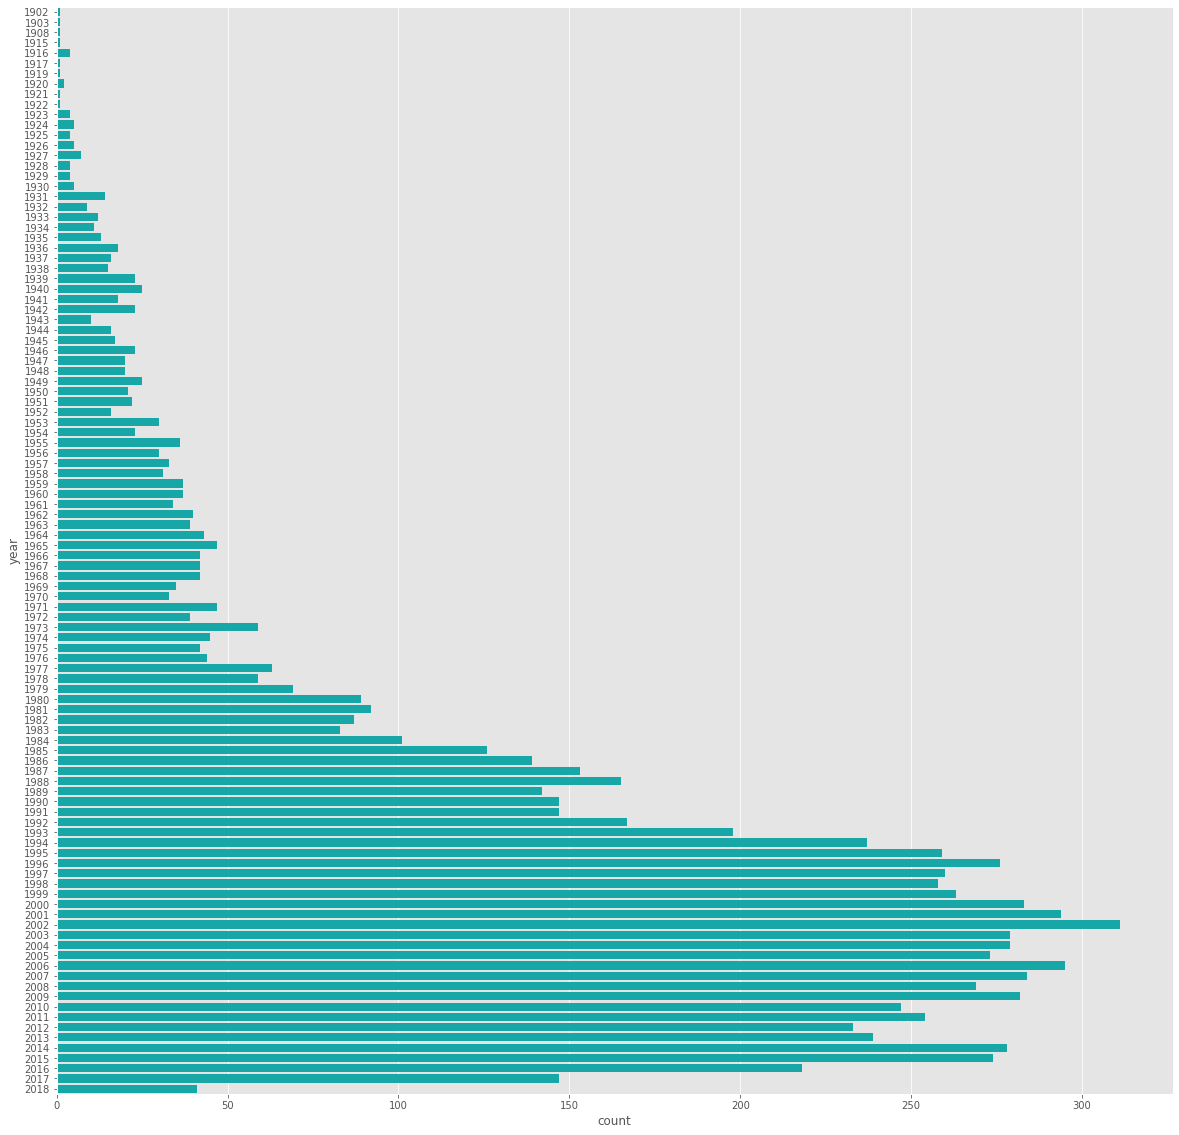

In [15]:
f, ax = plt.subplots(figsize=(20, 20))
sns.countplot(y="year", data=movies, color="c");

#### Genres

In [24]:
# Categorize movies genres properly.
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

In [26]:
movies.head(2)

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),1995,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
distribution_genres = movies.iloc[:,3:].sum(axis=0)

In [51]:
distribution_genres.index

Index(['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western'],
      dtype='object')

Text(0.5, 1.0, 'Genres distribution')

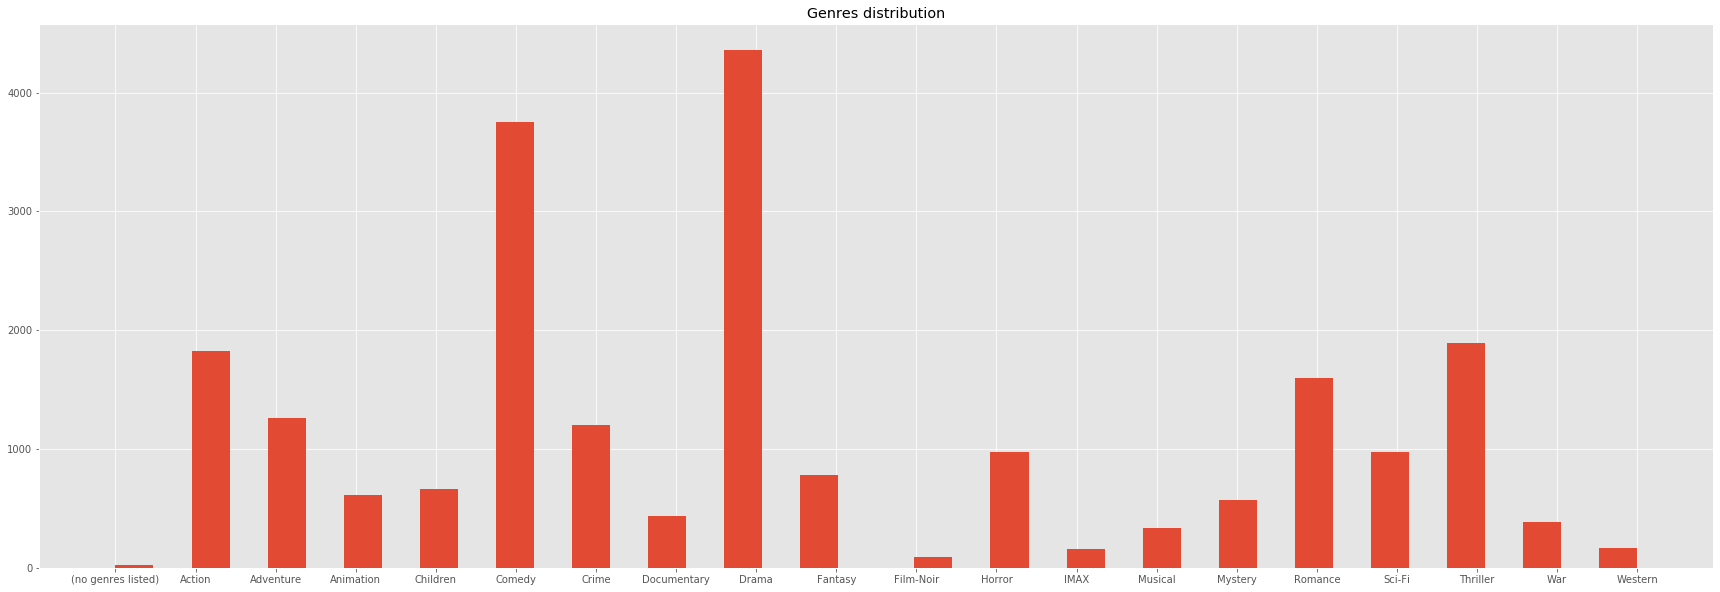

In [62]:
plt.figure(figsize=(30,10))
plt.hist(distribution_genres.index , weights=distribution_genres.values, bins=40)
plt.title("Genres distribution")

#### Ratings

**Average number of rated films**: 165.30491803278687
**Median number of rated films**: 70.5


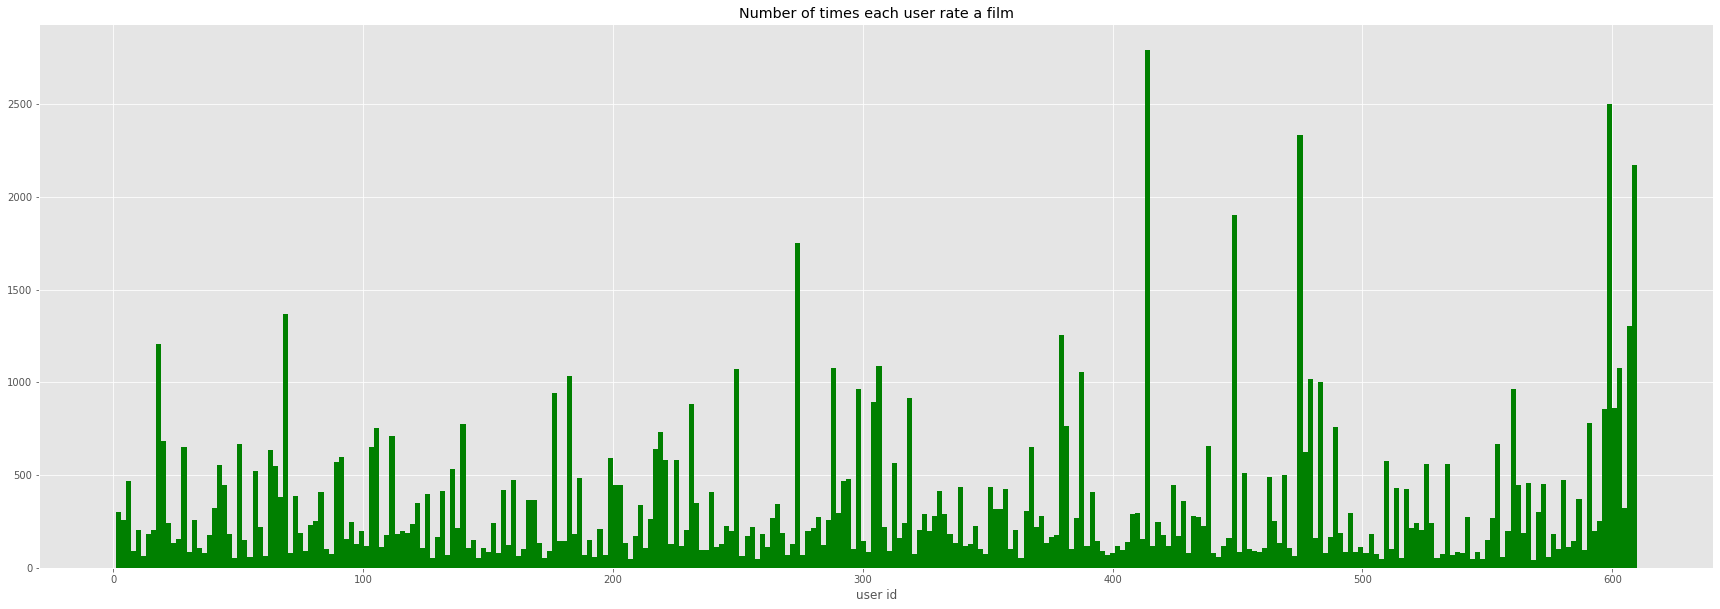

In [84]:
# amount of ratings each person gave
user_rating = ratings.groupby(['userId'])['rating'].count()

plt.figure(figsize=(30,10))
plt.hist(user_rating.index , weights=user_rating.values, bins=300, color = 'green')
plt.title("Number of times each user rate a film")
plt.xlabel('user id');
print("**Average number of rated films**:", ratings.groupby(['userId'])['rating'].count().mean())
print("**Median number of rated films**:", ratings.groupby(['userId'])['rating'].count().median())

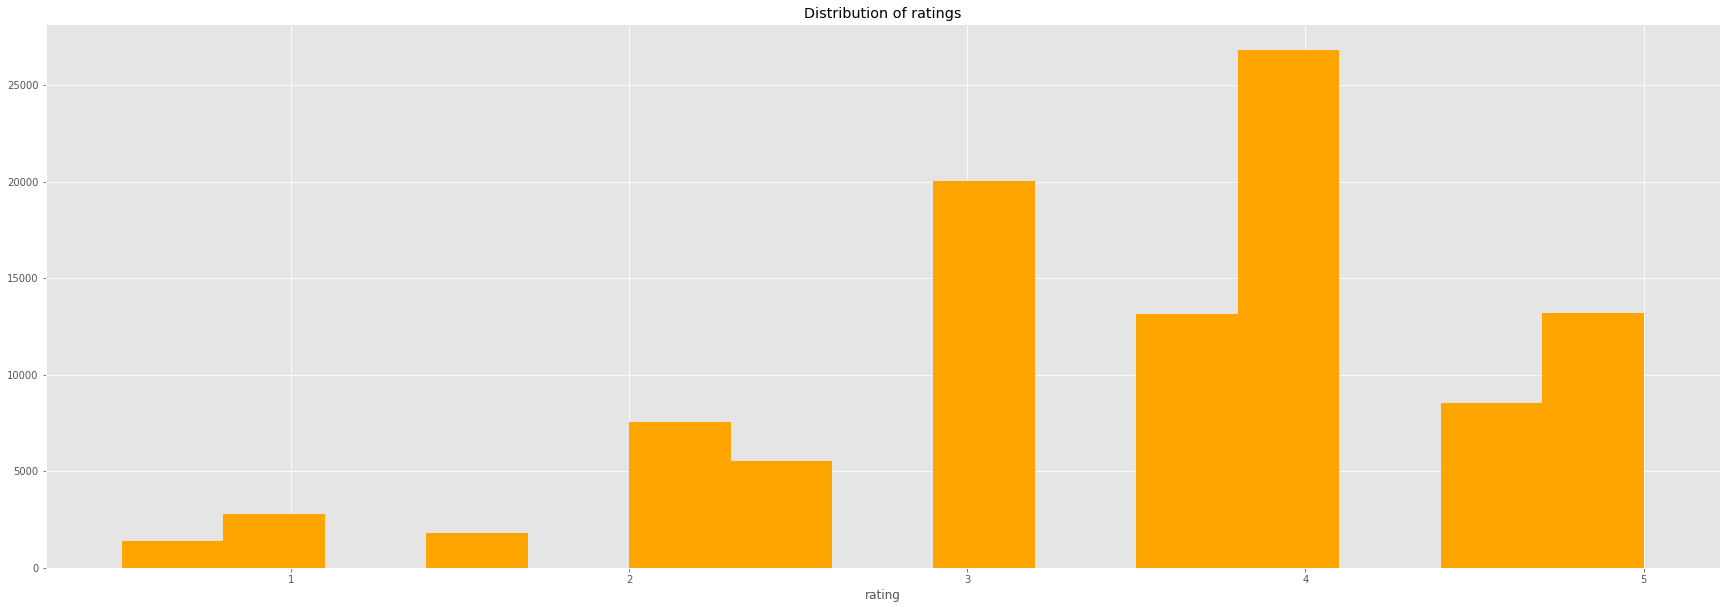

In [108]:
# Distribution of ratings
plt.figure(figsize=(30,10))
plt.hist(list(dict(ratings.rating.value_counts()).keys())  , 
         weights=list(dict(ratings.rating.value_counts()).values()), 
         bins=15, 
         color = 'orange')
plt.title("Distribution of ratings")
plt.xlabel('rating');
